# 4.5 규제가 있는 선형 모델

- 과대적합을 감소시키는 좋은 방법: 모델 규제(제한)
- 다항 회귀 모델 규제: 다항식 차수 감소
- 선형 회귀 모델: 가중치 제한
- ex) 릿지회귀, 라쏘회귀, 엘라스틱넷

## 4.5.1 릿지 회귀

- 규제가 추가된 선형 회귀 버전
- 규제항이 비용 함수에 추가
-> 모델의 가중치가 가능한 한 작게 유지
- 모델 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가

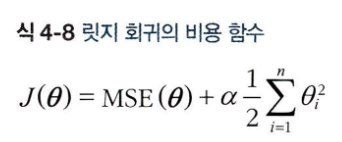
- 하이퍼파라미터 𝛼: 모델을 얼마나 많이 규제할지 조절
- 𝛼 = 0: 릿지 회귀는 선형 회귀와 같아짐
- 𝛼가 아주 클 때: 모든 가중치가 거의 0에 가까워지고 데이터 평균을 지나는 수평선이 됨

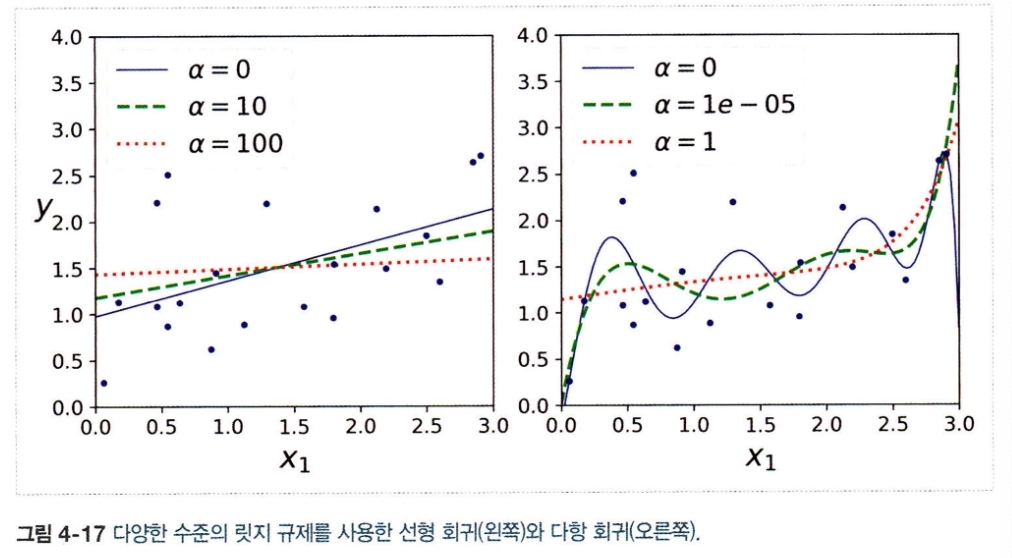

- 몇 가지 다른 𝛼를 사용해 릿지 모델 훈련 결과
- 왼쪽) 평범한 릿지 모델을 사용해 선형적 예측
- 오른쪽) PolynomialFeatures(degree=10)을 사용해 먼저 데이터 확장, StandardScaler를 사용해 스케일 조정 후 릿지 모델 적용 -> 릿지 규제를 사용한 다항 회귀
- 𝛼 증가할수록 직선에 가까워짐. 즉, 모델의 분산은 줄지만 편향은 커지게 됨.

In [5]:
import numpy as np

In [6]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [7]:
# 정규방정식을 사용한 릿지 회귀 적용 예
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([5.03980206])

In [8]:
# 확률적 경사 하강법 예
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.02207257])

## 4.5.2 라쏘(Lasso) 회귀

- 선형 회귀의 또 다른 규제 버전
- 릿지 회귀처럼 비용함수에 규제항을 더하지만, 𝑙2 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 𝑙1 노름 사용

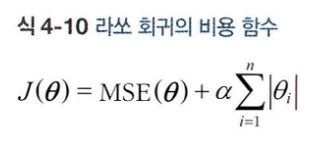

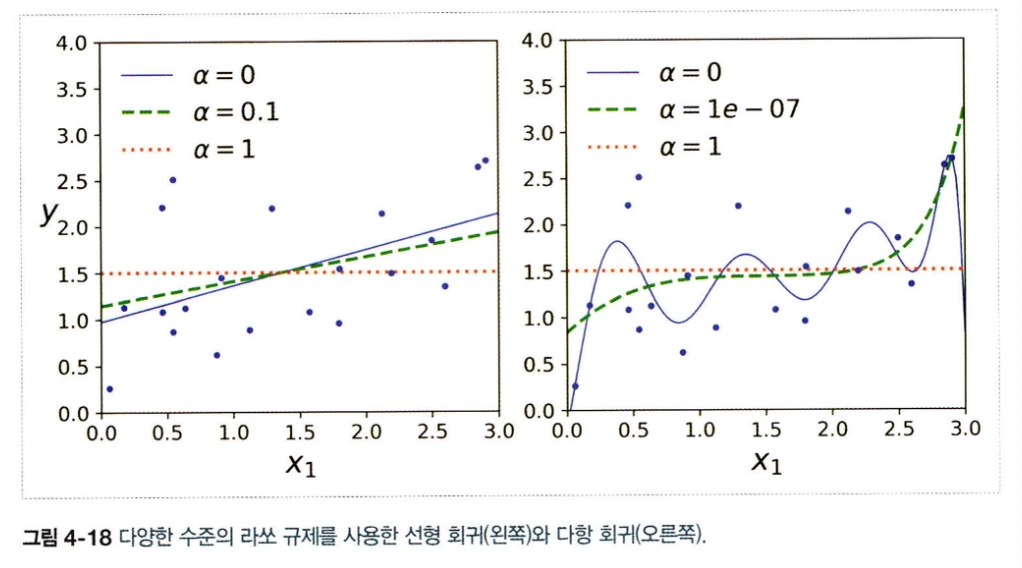

- 라쏘 회귀의 중요 특징: 덜 중요한 가중치 제거(즉, 가중치가 0이 됨)
- 오른쪽) 점선은 2차 방정식처럼 거의 선형적. 차수가 높은 다항 특성의 가중치가 모두 0이 됨. -> 자동으로 특성 선택을 하고 **희소 모델** 을 만듦. (즉, 0이 아닌 특성의 가중치가 적음)

- 왼쪽) 축에 가까워지면 선형적으로 줄어듦.
- 오른쪽) 등고선은 라쏘 손실 함수를 나타냄. (즉 𝑙1 손실을 더한 MSE 손실 함수)

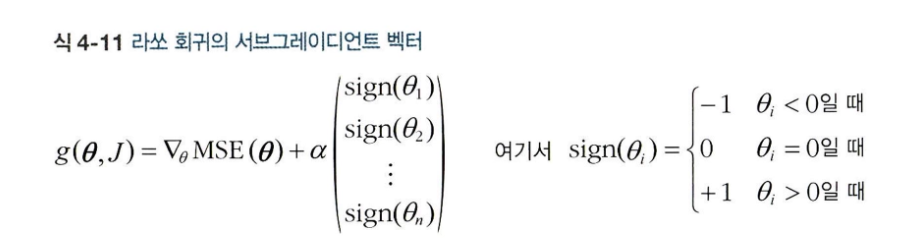

- 라쏘의 비용 함수는 𝛳i=0(i=1,2,...,n일 때)에서 미분 불가
- 하지만 𝛳i=0일 때 **서브그레이디언트 벡터 g** 를 사용하면 경사 하강법 적용 가능

In [9]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.99240909])

## 4.5.3 엘라스틱넷

- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 규제항은 릿지와 회귀의 규제항을 단순해 더해 사용, 혼합 정도는 혼합 비율 r을 사용해 조절
- r=0이면 엘라스틱넷은 릿지 회귀와 같고, r=1이면 라쏘 회귀와 같음

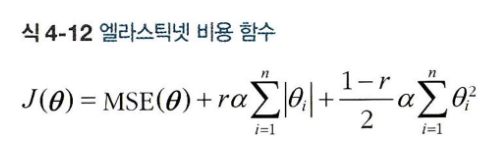

In [10]:
# l1_ratio가 혼합 비율 r을 의미
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.9920619])

## 4.5.4 조기 종료

- 경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 색다른 방식은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

In [21]:
from sklearn.base import clone
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

In [23]:
# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # 훈련 이어서 진행
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

# 4.6 로지스틱 회귀(또는 로짓 회귀)

- 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용
- 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측(즉, 레이블이 '1'인 양성 클래스)
- 아니면 클래스에 속하지 않는다고 예측(즉, 레이블이 '0'인 음성 클래스)
- 이를 이진 분류기라고 함.

## 4.6.1 확률 추정

- 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산
- 결괏값의 로지스틱을 출력
- 로지스틱은 0과 1 사이의 값을 출력하는 **시그모이드 함수** 임

## 4.6.2 훈련과 비용 함수

- 훈련의 목적은 양성 샘플(y=1)에 대해서는 높은 확률을 추정, 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 𝛳를 찾는 것.

## 4.6.3 결정 경계

In [24]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [25]:
X = iris["data"][:,3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(int) # 1 Iris-Virginiva면 1, 그렇지 않으면 0

In [26]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

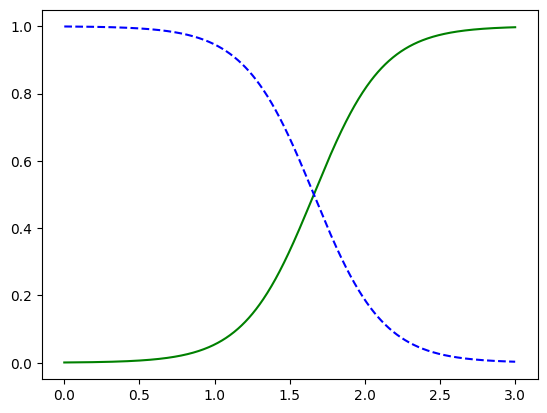

In [27]:
import matplotlib.pyplot as plt

X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not Iris virginica")

In [28]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## 4.6.4 소프트맥스 회귀(또는 다항 로지스틱 회귀)

- 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화 가능
- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 s_k(x)를 계산, 그 점수에 **소프트맥스 함수(또는 정규화된 지수 함수)** 를 적용해 각 클래스의 확률을 추정
- 각 클래스는 자신만의 파라미터 벡터 𝛳(k)가 있음. 이 벡터들은 **파라미터 행렬 𝚯** 에 행으로 저장

- **크로스 엔트로피(cross entropy)** : 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합

In [29]:
X = iris["data"][:,(2,3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [30]:
softmax_reg.predict([[5,2]])

array([2])

In [31]:
softmax_reg.predict_proba([[5,2]])

array([[6.21626374e-07, 5.73689802e-02, 9.42630398e-01]])